<a href="https://colab.research.google.com/github/nadnik13/sparse_grid/blob/main/BuiltSimpleGrig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit
import matplotlib.pyplot as plt
import math
import numpy as np
from numba import cuda

In [ ]:
n = 256

blockdim = 16, 16
griddim = int(n/blockdim[0]), int(n/blockdim[1])

n = 4
@cuda.jit( device=True)
def fun(x:float) -> (float):
    return math.sin(10 * x - 0.1)

@cuda.jit( device=True)
def xli(l: int, i: int) ->(float):
    return i * (2 ** (-1. * l))

@cuda.jit()
def eval_a(grid_size, grid, a):
    i = cuda.grid(1)
    if i < grid_size:
        e = grid[i]
        temp = fun(xli(e[0], e[1]))
        if e[0] == 1:
            temp += -0.5 * (fun(xli(e[0], e[1]- 1)) + fun(xli(e[0], e[1] + 1)))
        elif (e[1] % 4 == 1 and e[0] > 1):
            temp += -0.125 * (3*fun(xli(e[0], e[1] - 1)) + 6*fun(xli(e[0], e[1] + 1)) - fun(xli(e[0], e[1] + 3)))
        elif (e[1] % 4 == 3 and e[0] > 1):
            temp += -0.125 * (3*fun(xli(e[0], e[1] + 1)) + 6*fun(xli(e[0], e[1] - 1)) - fun(xli(e[0], e[1] - 3)))
#     print(f"a = {e['a']}")
#         print(f"e['l']={e[0]} e['i']={e[1]} a_recursion={temp}")
        a[i] = temp
        

In [ ]:
@cuda.jit( device=True)  
def phi_1(x: float) -> (float):
    if -1 <= x <= 1:
        return 1 - abs(x)
    return 0.

@cuda.jit( device=True)   
def phi_2(x: float) -> (float):
    if -1 <= x <= 1:
        return - (x-1)*(x+1)
    return 0.

@cuda.jit( device=True)
def phi_li(l: int, i: int, x: float) -> (float):
    if l == 0:
        return phi_1(x * 2 ** l - i)
    else:
        return phi_2(x * 2 ** l - i)

@cuda.jit()
def eval_y(size, hx, grid_size, grid, a, y, err):
    i = cuda.grid(1)
    if i < size:
        r = 0
        x = i * hx
        for j in range(grid_size):
            e = grid[j]
            r += a[j] * phi_li(e[0], e[1], x)
        err[i] = r - fun(x)
        y[i] = r

In [ ]:
grid = [[1,1]]
n = 5

for e in grid:
    if e[0] == n: #or abs(e['a']) < 1e-3:
        continue
    grid.append([e[0] + 1, 2 * e[1] - 1])
    grid.append([e[0] + 1, 2 * e[1] + 1])

grid.append([ 0, 0 ])
grid.append([ 0, 1])

grid_size = len(grid)
print(grid_size)

33


In [ ]:
def gpu_func(n):
  # numba.cuda.device_array(shape, dtype=np.float, strides=None, order='C', stream=0)¶
  # a = np.zeros(grid_size)
  d_grid = cuda.to_device(grid)
  # d_a = cuda.to_device(a)
  d_a = cuda.device_array(shape = (grid_size), dtype=np.float)
  cnt_points = 101
  hx = 1. / (cnt_points-1)

  err = np.zeros(cnt_points)
  d_err = cuda.to_device(err)

  # res_y = np.zeros(cnt_points)
  d_y = cuda.device_array(shape = (cnt_points), dtype=np.float)

  eval_a[griddim,blockdim](grid_size, d_grid, d_a1)
  cuda.synchronize()

  eval_y[griddim,blockdim](cnt_points, hx, grid_size, d_grid, d_a, d_y, d_err)
  cuda.synchronize()

In [ ]:
#глобальные переменные 
grid = []
n = 5
cnt_points = 10001
res_y = []

In [ ]:
# Функция, которую строим
def fun(x):
    return math.sin(10 * x - 0.1)

def xli(l, i):
    return i * (2 ** (-l))

def add_a(e):
    e['a'] = fun(xli(e['l'], e['i']))
#     print(f"add_a: i={e['i']} l={e['l']} e['i'] // 4={e['i'] % 4} e['i'] // 3={e['i'] % 3}")
    if e['l'] == 1:
        e['a'] += -0.5 * (fun(xli(e['l'], e['i']- 1)) + fun(xli(e['l'], e['i'] + 1)))
    elif (e['i'] % 4 == 1 and e['l'] > 1):
        e['a'] += -0.125 * (3*fun(xli(e['l'], e['i'] - 1)) + 6*fun(xli(e['l'], e['i'] + 1)) - fun(xli(e['l'], e['i'] + 3)))
    elif (e['i'] % 4 == 3 and e['l'] > 1):
        e['a'] += -0.125 * (3*fun(xli(e['l'], e['i'] + 1)) + 6*fun(xli(e['l'], e['i'] - 1)) - fun(xli(e['l'], e['i'] - 3)))
#     print(f"a = {e['a']}")
#     print(f"e['l']={e['l']} e['i']={e['i']} a_recursion={e['a']}")
    return e

def phi_li(l, i, x):
    if l == 0:
        return phi_1(x * 2 ** l - i)
    else:
        return phi_2(x * 2 ** l - i)

#фи для краев
def phi_1(x):
    if -1 <= x <= 1:
        return 1 - abs(x)
    return 0

#фи для внутренних точек
def phi_2(x):
    if -1 <= x <= 1:
        return - (x-1)*(x+1)
    return 0

def eval(x):
    r = 0
    for e in grid:
        r += e['a'] * phi_li(e['l'], e['i'], x)
    return r


def cpu_func(n, cnt_points):
  grid = [add_a({'l': 1, 'i': 1})]
  for e in grid:
      if e['l'] == n: #or abs(e['a']) < 1e-3:
          continue
      grid.append(add_a({'l': e['l'] + 1, 'i': 2 * e['i'] - 1}))
      grid.append(add_a({'l': e['l'] + 1, 'i': 2 * e['i'] + 1}))

  grid.append(add_a({'l': 0, 'i': 0}))
  grid.append(add_a({'l': 0, 'i': 1}))

  error = 0
  for i in range(cnt_points):
      x = i * (1./cnt_points)
      error = max(error, abs(eval(x) - fun(x)))
      res_y.append(eval(x))
      
%timeit cpu_func(n, cnt_points)

100 loops, best of 5: 11.1 ms per loop


In [ ]:
def hfun(x):
    temp = math.sin(10 * x - 0.1)
    return temp

def hxli(l, i):
    return i * (2 ** (-1.*l))

ValueError: ignored

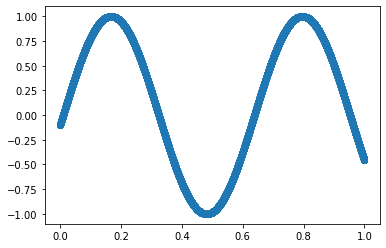

In [ ]:
xt = np.linspace(0,1,cnt_points)
yt = [hfun(x) for x in np.linspace(0,1,cnt_points)]
plt.plot(xt, yt, 'o')

x = np.linspace(0,1,cnt_points)
plt.plot(x, res_y)
plt.show()